In [1]:
import pandas as pd
import numpy as np

## 1、读取数据

In [2]:
# wine_white = pd.read_csv(r'C:\Users\MrFive1001\Documents\PycharmProjects\Kaggle\learning5\winequality-white.csv',sep=';')
wine_red = pd.read_csv(r'C:\Users\MrFive1001\Documents\PycharmProjects\Kaggle\learning5\winequality-red.csv',sep=';')
wine_red.head()  #读取前五行，使用'；'分隔符

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
# X_red = wine_red.iloc[:,:-1].values.copy()  # 去除质量列得到X列也能用
X_red = wine_red.iloc[:,:-1].as_matrix().copy() # 去除质量列得到X列
Y_red = wine_red['quality'].values.copy()  # 将质量列作为Y列
Y_red[Y_red<7] = 0  # 将质量二值化
Y_red[Y_red>=7] = 1

## 2、分类评估

In [4]:
from sklearn.ensemble import RandomForestClassifier # 导入随机森林分类器
from sklearn.cross_validation import cross_val_score # 导入交叉验证评价
from sklearn.model_selection import GridSearchCV
import seaborn as sns #导入画图函数
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
par = {'n_estimators': range(1,41)}  # 改变的分类器参数
randomForest = GridSearchCV(RandomForestClassifier(),param_grid=par,cv=10) #10折交叉验证
randomForest.fit(X_red,Y_red) # 喂数据

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(1, 41)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

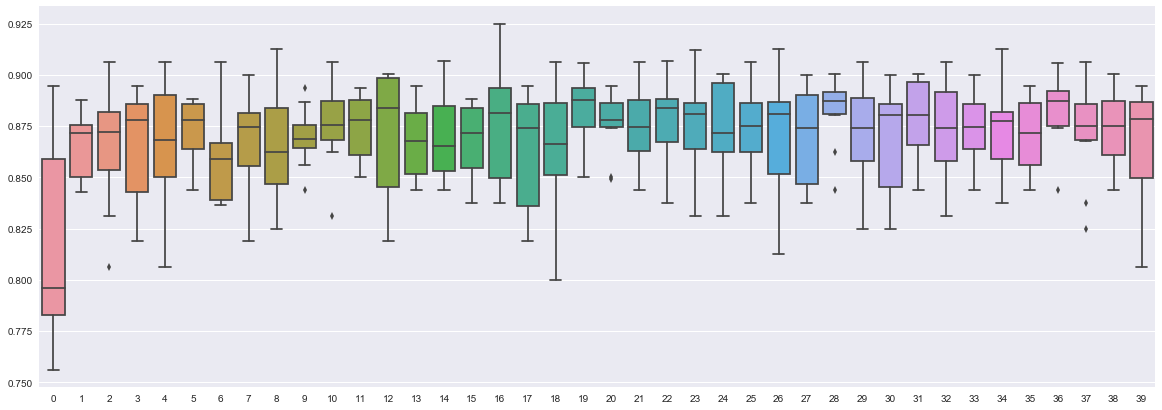

In [6]:
result = [np.array([randomForest.cv_results_['split'+str(j)+'_test_score'][i] for j in range(10)]) for i in range(40)]  #得到数据
fig = plt.figure(figsize=(20,7))
sns.boxplot(data=result)  #画出箱状图
plt.show()

In [7]:
bad = 1 - Y_red.sum()/len(Y_red)# 
bad

0.86429018136335212

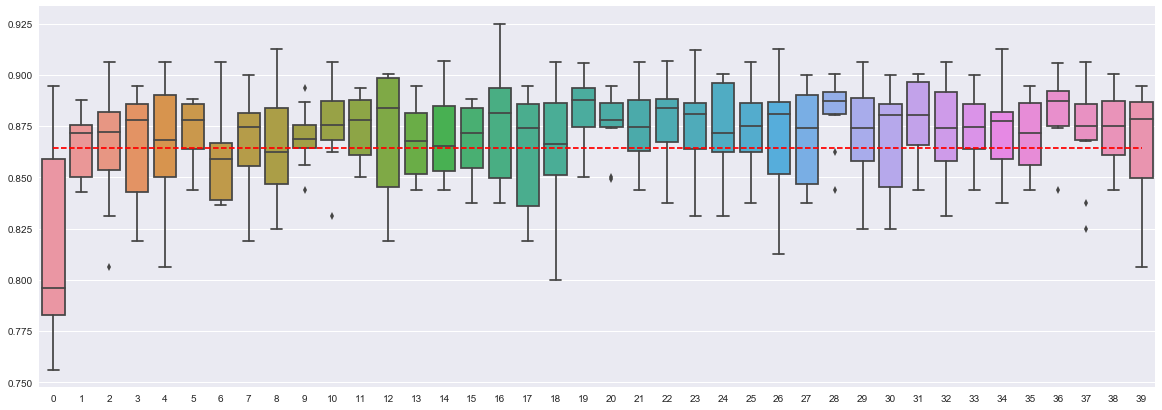

In [8]:
fig = plt.figure(figsize=(20,7))
sns.boxplot(data=result)  #画出箱状图
plt.plot(range(40),40*[bad],'r--')
plt.show()

查准率：例如对于告诉病人病情的时候，如果不想使病人慌张，查准率就会比较重要。
查全率：在使用搜索时候，我们需要查的越多越好

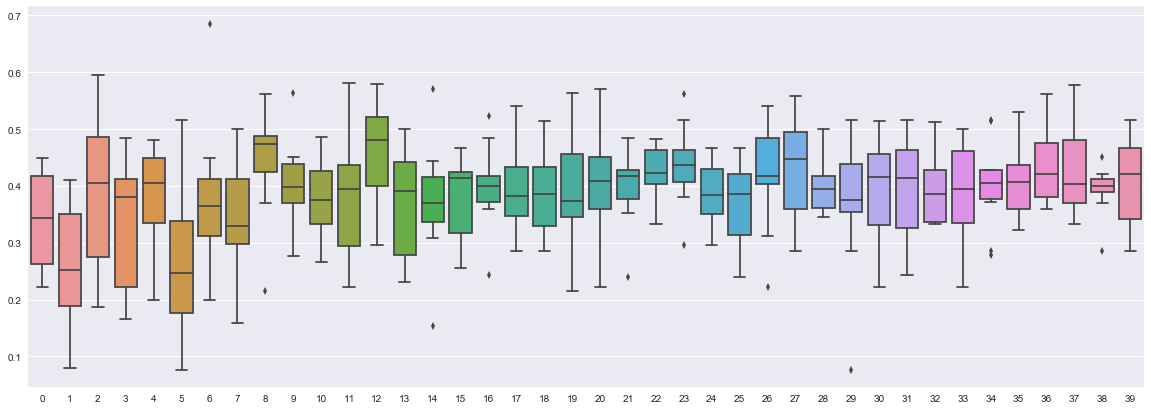

In [9]:
par = {'n_estimators': range(1,41)}  # 改变的分类器参数
randomForest = GridSearchCV(RandomForestClassifier(),param_grid=par,cv=10,scoring='f1') #10折交叉验证
randomForest.fit(X_red,Y_red) # 喂数据
result = [np.array([randomForest.cv_results_['split'+str(j)+'_test_score'][i] for j in range(10)]) for i in range(40)]  #得到数据
fig = plt.figure(figsize=(20,7))
sns.boxplot(data=result)  #画出箱状图
plt.show()

## 3、分类器校准
自定义分类阈值

In [10]:
from sklearn import metrics
randomForest1 = RandomForestClassifier(n_estimators=15)  # 定义随机森林
randomForest1.fit(X_red,Y_red)  
Y_pre = randomForest1.predict_proba(X_red) #计算属于某个类的概率
Y_pre = np.array([1 if x > 0.5 else 0 for x in Y_pre[:,1]])
rate = 0
print(randomForest1.score(X_red,Y_red))
print(metrics.accuracy_score(Y_pre,Y_red)) # 评价准确率
for i in range(len(Y_pre)):
    if Y_pre[i] == Y_red[i]:
        rate += 1
rate = rate/len(Y_pre)
rate

0.998123827392
0.998123827392


0.99812382739212

In [11]:
def cutoff_predict(clf,X,cutoff):  #定义阈值分类器
    Y = clf.predict_proba(X)
    Y = np.array([1 if x > cutoff else 0 for x in Y[:,1]])
    return Y

In [12]:
from sklearn.model_selection import KFold  #K折交叉分类
groups_K = KFold(n_splits = 10,shuffle=True)
groups_K.get_n_splits(X_red)
X_train_list = []
Y_train_list = []
X_test_list = []
Y_test_list = []
for train_index, test_index in groups_K.split(X_red):
    X_train_list.append(X_red[train_index])
    X_test_list.append(X_red[test_index])
    Y_train_list.append(Y_red[train_index])
    Y_test_list.append(Y_red[test_index])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set 

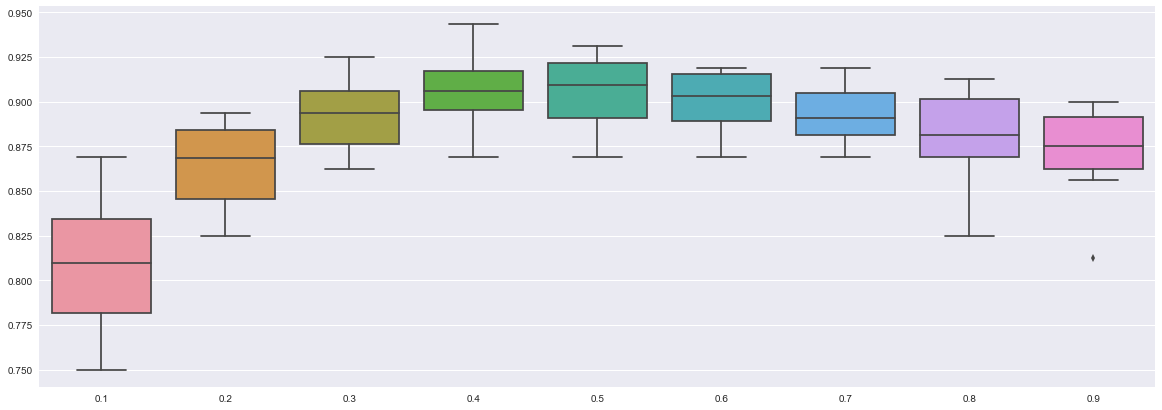

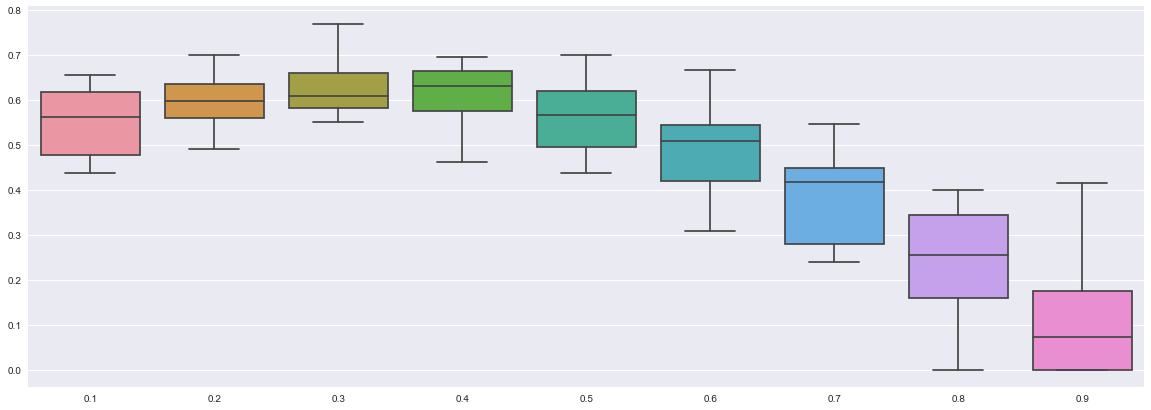

In [13]:
from sklearn import metrics
results = []
scores = []
# def cutoff_predict(clf, X, cutoff):
#     return (clf.predict_proba(X)[:,1] > cutoff).astype(int)
for cut in np.arange(0.1,1,0.1):
    result1 = []
    scores1 = []
    for i in range(10):
        ran = RandomForestClassifier()
        ran.fit(X_train_list[i],Y_train_list[i])
        Y = cutoff_predict(ran,X_test_list[i],cut)
        result1.append(metrics.accuracy_score(Y,Y_test_list[i])) #准确率来进行判断
        scores1.append(metrics.f1_score(Y,Y_test_list[i])) #F1分数来进行判断
    results.append(np.array(result1))
    scores.append(np.array(scores1))
fig1 = plt.figure(figsize=(20,7))
sns.boxplot(y=results,x = np.arange(0.1,1,0.1))
fig1 = plt.figure(figsize=(20,7))
sns.boxplot(y=scores,x = np.arange(0.1,1,0.1))
plt.show()   #可以看出0.4的时候比较好

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The box

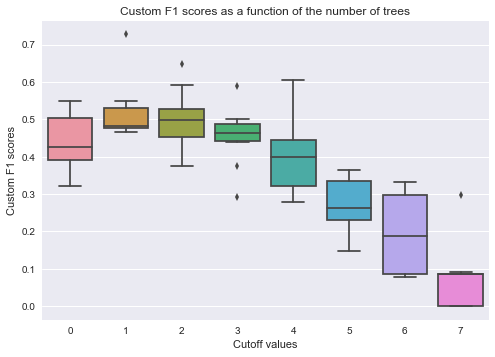

In [14]:
# 标准答案
scores = []
def cutoff_predict(clf, X, cutoff):
    return (clf.predict_proba(X)[:,1] > cutoff).astype(int)
def custom_f1(cutoff):
    def f1_cutoff(clf, X, y):
        ypred = cutoff_predict(clf, X, cutoff)
        return metrics.f1_score(y, ypred)
        
    return f1_cutoff

## Your code here
for cutoff in np.arange(0.1,0.9,0.1):
    clf = RandomForestClassifier(n_estimators = 15)
    score_list = cross_val_score(clf, X_red, Y_red, cv=10, scoring=custom_f1(cutoff))   
    scores.append(score_list)
sns.boxplot(data=scores, names=np.arange(0.1,0.9,0.1))
plt.xlabel('Cutoff values')
plt.ylabel('Custom F1 scores')
plt.title('Custom F1 scores as a function of the number of trees')
plt.show()

## 4、使用决策表面可视化分类

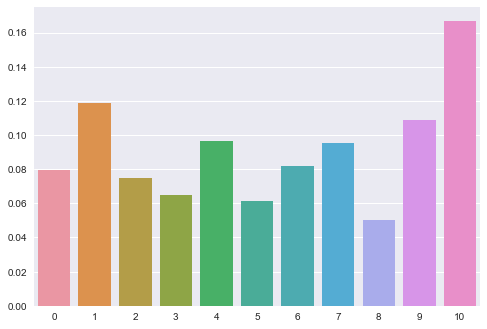

In [15]:
# 选取两个主要特征
ran = RandomForestClassifier(n_estimators=15)
ran.fit(X_red,Y_red)
sns.barplot(y = ran.feature_importances_,x = np.arange(len(ran.feature_importances_)))
plt.show()

In [16]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired)
    plt.show()

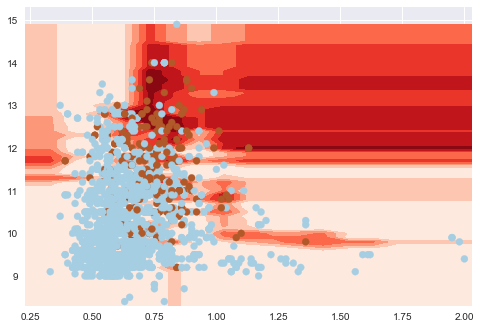

In [17]:
X = X_red[:,-2:].copy()
Y = Y_red.copy()  # 得到后面两个比较大的特征
ran = RandomForestClassifier(n_estimators=15)
plot_decision_surface(ran,X,Y)   #看不懂画的是啥

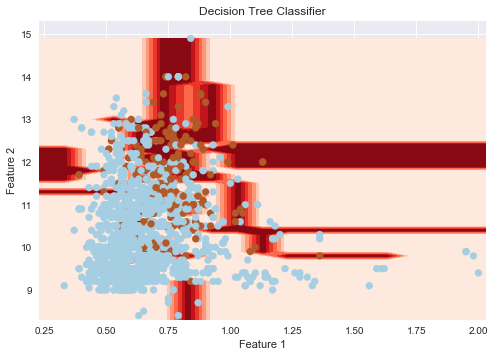

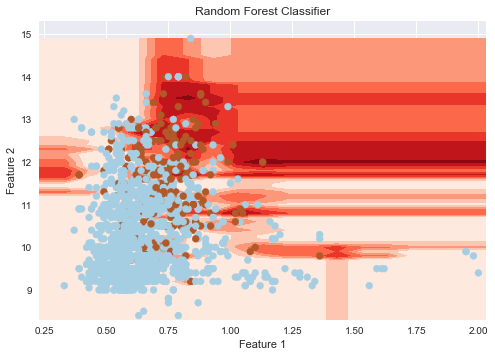

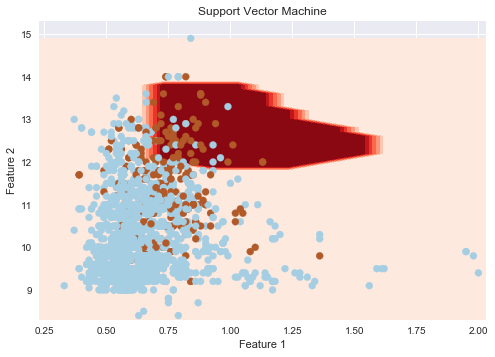

In [18]:
# 标准答案
classifiers = [DecisionTreeClassifier(),
               RandomForestClassifier(n_estimators=15),
               sklearn.svm.SVC(C=100.0, gamma=1.0)]

titleClassifer = ['Decision Tree Classifier', 'Random Forest Classifier', 
                  'Support Vector Machine']
for c in range(3):
    plt.title(titleClassifer[c])
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plot_decision_surface(classifiers[c], X, Y)